<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90_sample_weight_C5IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [2]:
import pandas as pd

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)

test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]
train = train.append(test_200)#加入200筆

train = train.reset_index(drop=True)
test_200 = test_200.reset_index(drop=True)
test_50 = test_50.reset_index(drop=True)

print('train',train.shape)
print('test_170',test_170.shape)
print('test_50',test_50.shape)

train (4721, 27)
test_170 (170, 27)
test_50 (50, 27)


In [3]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


In [0]:
features = ['T10','T50','T90','N+A']
y_columns = train.columns.tolist()[4:]
y_name = 'C5IP'

# features scaler

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train[features])

train[features] = scaler.transform(train[features])
test_170[features] = scaler.transform(test_170[features])
test_50[features] = scaler.transform(test_50[features])

# corr with x

In [6]:
corrs = train[features+[y_name]].corr()
abs(corrs)

,T10,T50,T90,N+A,C5IP
T10,1.000000,0.895238,0.222087,0.262210,0.916974
T50,0.895238,1.000000,0.533778,0.371996,0.810627
T90,0.222087,0.533778,1.000000,0.217989,0.204262
N+A,0.262210,0.371996,0.217989,1.000000,0.161195
C5IP,0.916974,0.810627,0.204262,0.161195,1.000000


# corr with y

In [7]:
y_corrs = train[y_columns].corr()[[y_name]]
y_corrs = abs(y_corrs).sort_values(by=y_name,ascending=False).head(10)
y_corrs

,C5IP
C5IP,1.000000
C5NP,0.968468
C6IP,0.891451
C9IP,0.730607
C8NP,0.693042
C8IP,0.652752
C9NP,0.637529
C5N,0.611124
C6N,0.594636
C6NP,0.586128


# 計算sample weight

In [8]:
import numpy as np
#step1 def a function can count each data's distance 
def count_distance(x1,x2):
  return sum((np.array(x1) - np.array(x2))**2)**(0.5)
#測試功能是否正常
print(train.loc[0,features].values)
print(test_50.loc[0,features].values)
print(count_distance(train.loc[0,features],test_50.loc[0,features]))
print(count_distance([ 0.45744396,  0.55635142,  0.43980873, -1.04756769],[-2.17447021, -2.01755028, -2.61401745, -0.20538368]))

#根據value排序回傳index
def sort_by_value(dict1):
  return sorted(dict1.items(), key=lambda d: d[1],reverse=False)

#測試
sort_by_value({'A':2,'B':1,'C':3})

#找到距離最短的資料index
def find_min_distance_data(x1,x2s):
  d = {}
  for ind,x2 in enumerate(x2s):
    d[ind] = count_distance(x1,x2)
  return sort_by_value(d)

[ 0.45744396  0.55635142  0.43980873 -1.04756769]
[-2.17447021 -2.01755028 -2.61401745 -0.20538368]
4.856652179297696
4.856652180655184


In [9]:
#計算距離和sample_weight,利用test_50地一筆資料計算與train4721資料彼此的距離
row = 0
n = 3
distance_map = dict(find_min_distance_data(test_50.loc[row,features+[y_name]].values,train.loc[:,features+[y_name]].values))
t = [ i for i in distance_map.items()]
t = t[:n]
print(t)

[(242, 0.6794023711762037), (257, 0.7921844956281572), (245, 0.9168509245758995)]


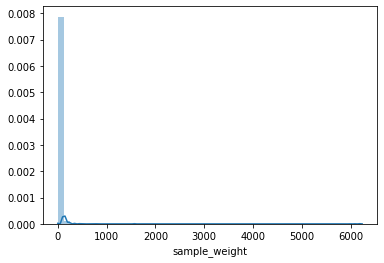

,sample_weight
0,2.860768
1,3.118291
2,2.885086
3,2.941264
4,3.147825


In [10]:
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
#樣本權重初始化為1
train['sample_weight'] = 1
#考慮鄰居數
n = 3
#對test50遍歷,計算與train sample的距離
for row in tqdm(test_50.index):
  distance_map = dict(find_min_distance_data(test_50.loc[row,features+[y_name]].values,train.loc[:,features+[y_name]].values))
  train['sample_weight'] = train['sample_weight'] + (1/train.index.map(distance_map))**3
sns.distplot(train['sample_weight']);plt.show()
train[['sample_weight']].head(5)

In [11]:
train.head(10)

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,sample_weight
0,0.457444,0.556351,0.439809,-1.047568,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319,2.860768
1,0.379525,0.366234,0.226254,-1.096167,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303,3.118291
2,0.414156,0.497854,0.247610,-1.122719,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289,2.885086
3,0.448786,0.468605,-0.328987,-1.109799,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281,2.941264
4,0.448786,0.395483,-0.478475,-1.022438,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290,3.147825
5,0.448786,0.322360,-0.264920,-0.999324,0.357,0.203,0.067,4.986,2.478,2.877,0.511,10.173,7.964,6.579,2.930,9.035,9.619,4.848,5.465,6.281,9.918,4.291,3.608,0.819,4.681,0.928,0.281,3.647131
6,0.414156,0.395483,-0.179499,-1.005606,0.374,0.005,0.068,5.009,0.212,2.902,0.516,10.186,2.491,6.602,2.934,9.006,7.986,4.732,5.456,6.239,9.597,4.319,3.578,0.810,14.673,0.876,0.349,3.299216
7,0.362210,0.336985,-0.350342,-0.993753,0.357,0.206,0.065,4.971,2.444,2.913,0.514,10.218,8.013,6.628,2.938,9.026,9.617,4.859,5.459,6.236,9.887,4.286,3.571,0.803,4.636,0.917,0.282,3.726111
8,0.440129,0.395483,-0.286276,-1.079809,0.351,0.202,0.065,4.965,2.431,2.913,0.513,10.234,8.025,6.637,2.941,9.029,9.622,4.858,5.461,6.237,9.888,4.281,2.842,0.802,5.350,0.914,0.281,3.237371
9,0.457444,0.424731,0.076766,-0.997190,0.397,0.236,0.069,4.982,2.461,2.939,0.522,10.229,8.025,6.655,2.950,9.021,9.611,4.858,5.460,6.232,9.894,4.221,3.550,0.799,4.602,0.900,0.279,3.560613


# plot

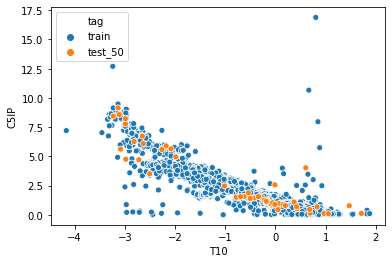

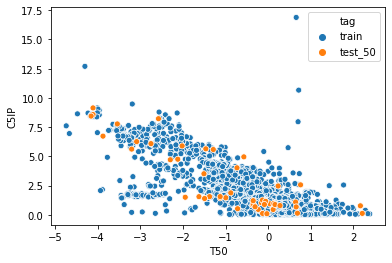

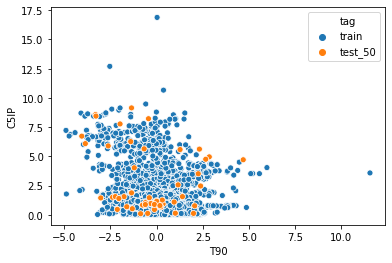

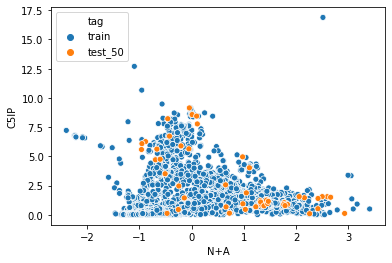

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
train['tag'] = 'train'
test_50['tag'] = 'test_50'
for col in features:
  sns.scatterplot(x = col,y = y_name ,data = train.append(test_50) ,hue='tag')
  plt.legend()
  plt.show()

In [0]:
def is_imp(S):
  if S>=train['sample_weight'].median():
    return True
  if S<train['sample_weight'].median():
    return False
train['imp'] = train['sample_weight'].apply(is_imp)

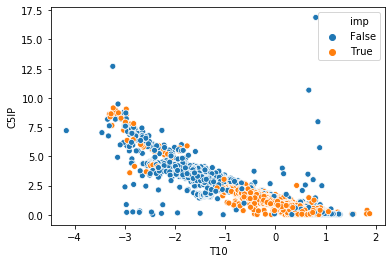

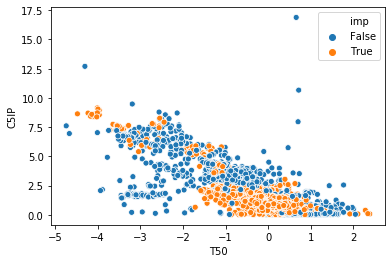

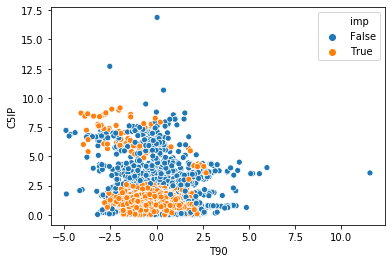

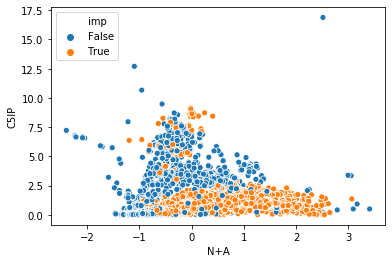

In [14]:
for col in features:
  sns.scatterplot(x = col,y = y_name ,data = train ,hue='imp')
  plt.legend()
  plt.show()

# metric

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import numpy as np
from math import sqrt
def metric(y_t,y_p,name):
  res = {'R2':np.max((r2_score(y_t,y_p),0)),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

# 全部資料有加權重

In [16]:
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

model_weights = SVR()
model_weights.fit(train[features],
                  train[y_name],
                  sample_weight = train['sample_weight'].values)
y_test = test_50[y_name]
y_pred = model_weights.predict(test_50[features])
metric(y_test,y_pred,'有加權重')

,R2,RMSE,mean_absolute_error
有加權重,0.917428,0.77089,0.447259


# 直接拿重要資料訓練 不加權

In [17]:
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

model_weights = LGBMRegressor()
model_weights.fit(train.loc[train['imp']==True,features],
                  train.loc[train['imp']==True,y_name])
y_test = test_50[y_name]
y_pred = model_weights.predict(test_50[features])
metric(y_test,y_pred,'重要資料不加權')

,R2,RMSE,mean_absolute_error
重要資料不加權,0.918278,0.766915,0.436545


# 對照組

In [18]:
svr = SVR()#一般SVR
svr.fit(train[features],train[y_name])#fit on train 4721
y_test = test_50[y_name]#50
y_pred = svr.predict(test_50[features])#50
metric(y_test,y_pred,'fit on train')

,R2,RMSE,mean_absolute_error
fit on train,0.914202,0.785806,0.466637


In [19]:
svr = SVR()#一般SVR
svr.fit(test_200[features],test_200[y_name])#fit on test 200
y_test = test_50[y_name]#50
y_pred = svr.predict(test_50[features])#50
metric(y_test,y_pred,'fit on 200')

,R2,RMSE,mean_absolute_error
fit on 200,0.0,2.785144,2.130095
